In [2]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [5]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 4*s]
train = train[train['trip_duration'] >= m - 4*s]

In [8]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [9]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test
###train.loc[:, 'dropoff_date'] = train['dropoff_datetime'].dt.date

In [10]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26


In [11]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,2016-06-30
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,2016-06-30
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,2016-06-30
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,2016-06-30
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,2016-06-30


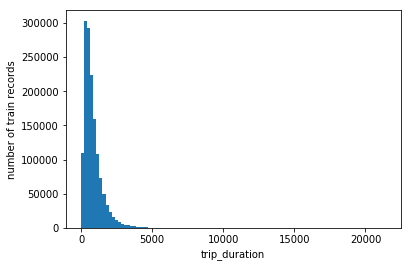

In [12]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

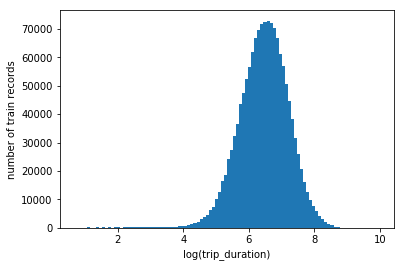

C:\Users\Nadeesha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


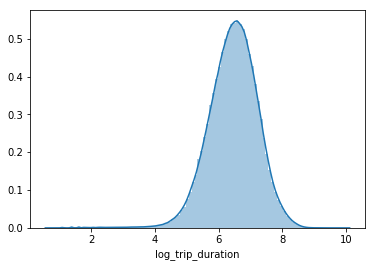

In [13]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

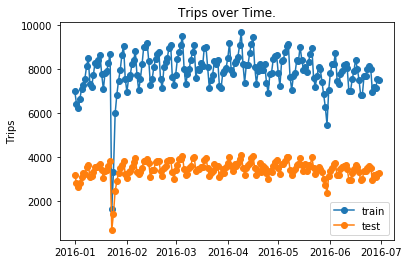

In [14]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

No handles with labels found to put in legend.


Text(0,0.5,'Time in Seconds')

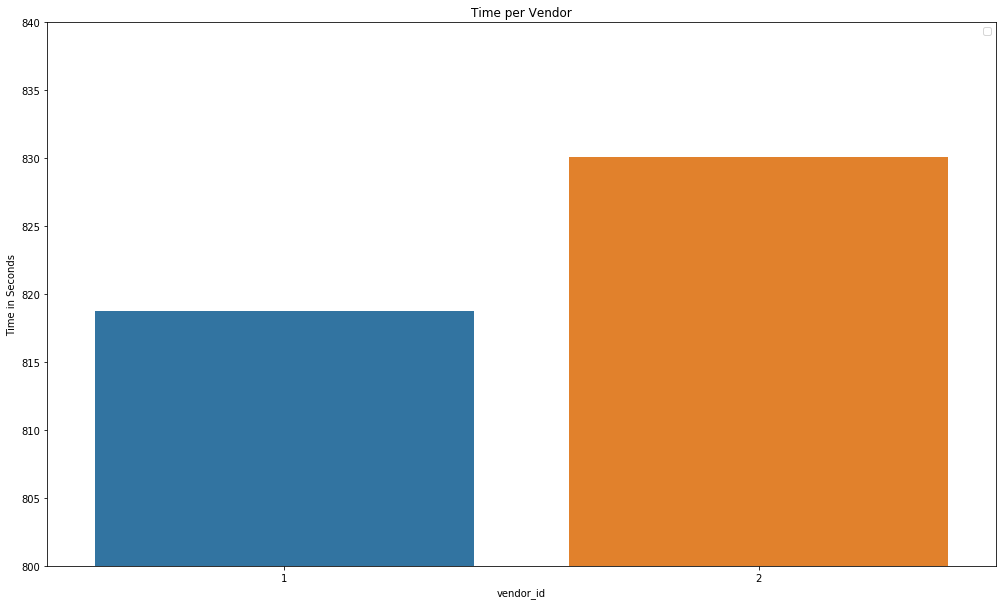

In [15]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

No handles with labels found to put in legend.


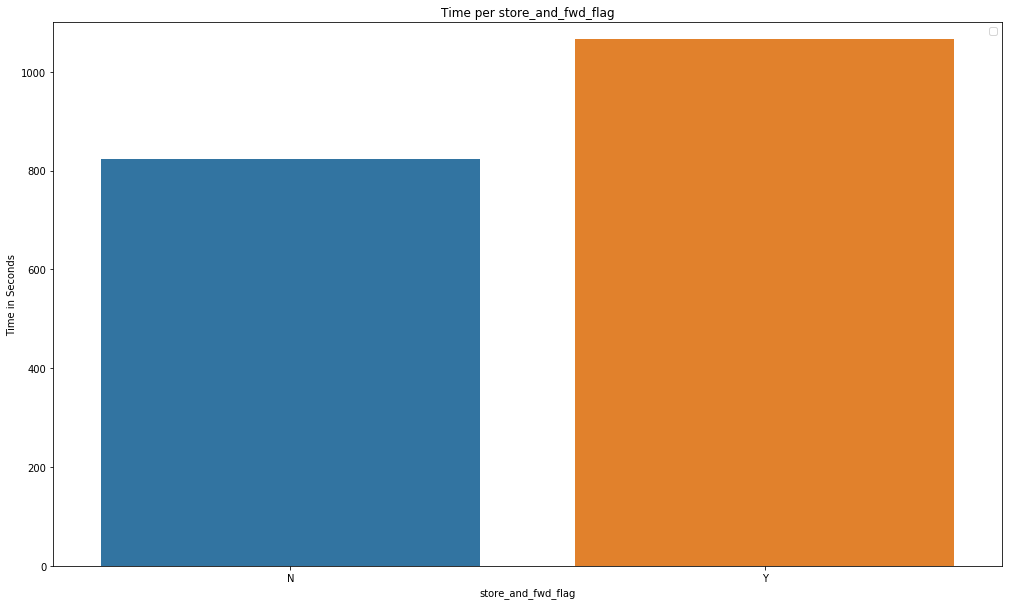

In [16]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

No handles with labels found to put in legend.


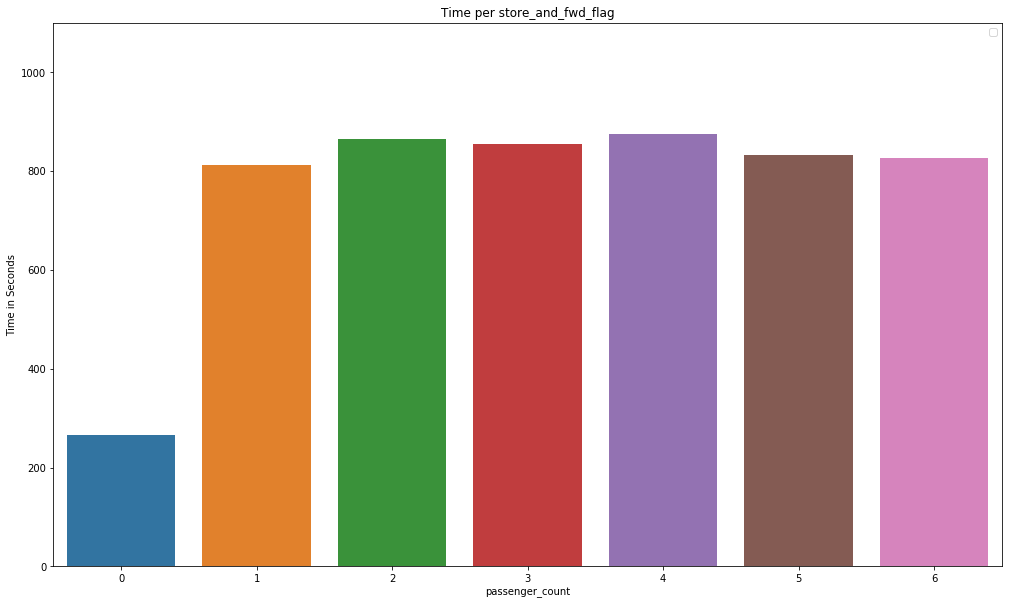

In [17]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [18]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018744
2     206869
3      58990
4      27957
5      76915
6      47641
dtype: int64

In [19]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

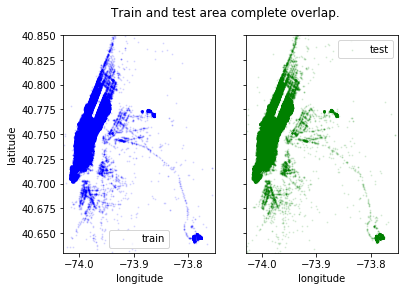

In [20]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [21]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [22]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [23]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [24]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [25]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

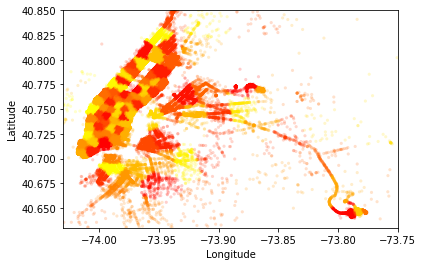

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [27]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [28]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226449
 2    235061
 3    252449
 4    247860
 5    244600
 6    230749
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [29]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [30]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [31]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

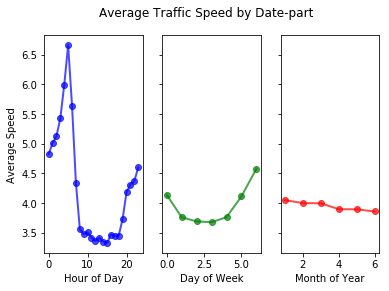

In [32]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

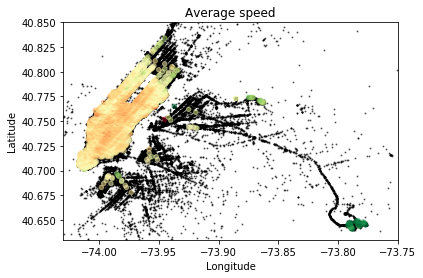

In [33]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [34]:
fr1 = pd.read_csv('fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [35]:
train.shape, test.shape

((1437168, 29), (625134, 22))

In [36]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,DayofMonth,Hour,dayofweek,avg_speed_h,avg_speed_m,pickup_lat_bin,pickup_long_bin,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,...,14,17,0,3.293,3.814,40.768,-73.982,2009.100,164.900,5.000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,...,12,0,6,2.723,3.666,40.739,-73.980,2513.200,332.000,6.000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,...,19,11,1,3.006,3.862,40.764,-73.979,11060.800,767.600,16.000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,...,6,19,2,3.463,3.873,40.720,-74.010,1779.400,235.800,4.000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,...,26,13,5,2.732,2.757,40.793,-73.973,1614.900,140.100,5.000


In [37]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [38]:
vendor_train.shape,vendor_test.shape

((1437168, 2), (625134, 2))

In [39]:
passenger_count_train.shape,passenger_count_test.shape

((1437168, 7), (625134, 8))

In [40]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape

((1437168, 2), (625134, 2))

In [41]:
cluster_pickup_train.shape,cluster_pickup_test.shape

((1437168, 100), (625134, 100))

In [42]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape

((1437168, 100), (625134, 100))

In [43]:
month_train.shape,month_test.shape

((1437168, 6), (625134, 6))

In [44]:
dom_train.shape,dom_test.shape

((1437168, 31), (625134, 31))

In [45]:
hour_train.shape,hour_test.shape

((1437168, 24), (625134, 24))

In [46]:
dow_train.shape,dow_test.shape

((1437168, 7), (625134, 7))

In [47]:
vendor_train.head()

,vi_1,vi_2
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1


In [48]:
passenger_count_train.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


In [49]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [50]:
passenger_count_train.shape,passenger_count_test.shape

((1437168, 7), (625134, 7))

In [51]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [52]:
train.shape,test.shape

((1437168, 11), (625134, 10))

In [53]:
train.head()

,pickup_datetime,pickup_date,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps
0,2016-03-14 17:24:55,2016-03-14,6.122,1.499,1.735,99.970,93,81,2009.100,164.900,5.000
1,2016-06-12 00:43:35,2016-06-12,6.498,1.806,2.431,-117.154,75,16,2513.200,332.000,6.000
2,2016-01-19 11:35:24,2016-01-19,7.662,6.385,8.204,-159.680,8,12,11060.800,767.600,16.000
3,2016-04-06 19:32:31,2016-04-06,6.064,1.485,1.661,-172.738,95,67,1779.400,235.800,4.000
4,2016-03-26 13:30:55,2016-03-26,6.078,1.189,1.199,179.474,21,89,1614.900,140.100,5.000


In [54]:
#train = train.drop(['dropoff_date'], axis = 1)

In [55]:
train.shape,test.shape

((1437168, 11), (625134, 10))

In [56]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_train,
                          dow_train
                         ], axis=1)

In [57]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [58]:
Train_Master.shape,Test_master.shape

((1437168, 290), (625134, 289))

In [59]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [60]:
Train_Master.shape,Test_master.shape

((1437168, 288), (625134, 287))

In [61]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [62]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [63]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [64]:
md = [6]
lr = [0.1,0.3]
mcw = [20,25,30]
for m in md:
    for l in lr:
        for n in mcw:
            t0 = datetime.now()
            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 
                        'max_depth': m,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10,
                  maximize=False, verbose_eval=1)
            print('Modeling iteration %s, RMSLE %.5f' % (xgb_pars, model.best_score))

[0]	train-rmse:5.40139	valid-rmse:5.40307
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:4.86524	valid-rmse:4.86658
[2]	train-rmse:4.38305	valid-rmse:4.38417
[3]	train-rmse:3.94954	valid-rmse:3.95029
[4]	train-rmse:3.55979	valid-rmse:3.56038
[5]	train-rmse:3.2094	valid-rmse:3.20986
[6]	train-rmse:2.89466	valid-rmse:2.8949
[7]	train-rmse:2.61206	valid-rmse:2.61224
[8]	train-rmse:2.35827	valid-rmse:2.35839
[9]	train-rmse:2.13059	valid-rmse:2.13062
[10]	train-rmse:1.92641	valid-rmse:1.92645
[11]	train-rmse:1.74366	valid-rmse:1.74373
[12]	train-rmse:1.57998	valid-rmse:1.58024
[13]	train-rmse:1.43377	valid-rmse:1.43425
[14]	train-rmse:1.30309	valid-rmse:1.30379
[15]	train-rmse:1.18659	valid-rmse:1.18758
[16]	train-rmse:1.08309	valid-rmse:1.08437
[17]	train-rmse:0.991229	valid-rmse:0.992781
[18]	train-rmse:0.909912	valid-rmse:0.911815
[19]	train-rmse:0.838081	valid-rmse:0.840326
[

[8]	train-rmse:0.472408	valid-rmse:0.476916
[9]	train-rmse:0.436574	valid-rmse:0.441656
[10]	train-rmse:0.416537	valid-rmse:0.422316
[11]	train-rmse:0.404197	valid-rmse:0.410924
[12]	train-rmse:0.397264	valid-rmse:0.404873
[13]	train-rmse:0.390987	valid-rmse:0.399276
[14]	train-rmse:0.387827	valid-rmse:0.396367
[15]	train-rmse:0.385025	valid-rmse:0.394488
[16]	train-rmse:0.382305	valid-rmse:0.392394
[17]	train-rmse:0.379292	valid-rmse:0.390276
[18]	train-rmse:0.377432	valid-rmse:0.388613
[19]	train-rmse:0.375883	valid-rmse:0.387733
[20]	train-rmse:0.374253	valid-rmse:0.386417
[21]	train-rmse:0.372256	valid-rmse:0.38529
[22]	train-rmse:0.371293	valid-rmse:0.384506
[23]	train-rmse:0.36964	valid-rmse:0.383551
[24]	train-rmse:0.368303	valid-rmse:0.382563
[25]	train-rmse:0.367216	valid-rmse:0.381894
[26]	train-rmse:0.366174	valid-rmse:0.381338
[27]	train-rmse:0.364755	valid-rmse:0.380678
[28]	train-rmse:0.36321	valid-rmse:0.379543
[29]	train-rmse:0.362528	valid-rmse:0.379139
[30]	train-rmse

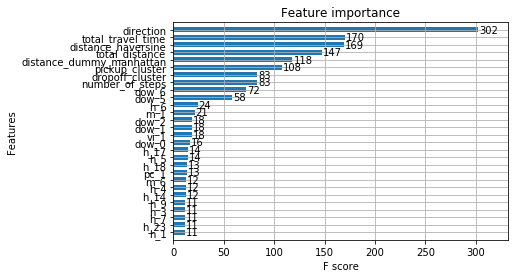

In [65]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

In [66]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [67]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission_xgboost.csv", index=False)

In [68]:
from sklearn.linear_model import Ridge, ElasticNet, Lasso

In [69]:
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)
score_lr = model_lr.score(X_test, Y_test)
pre2 = model_lr.predict(Test_master)
pre2 = np.exp(pre2) - 1
pre2
submission_lr = pd.concat([Test_id, pd.DataFrame(pre2)], axis=1)
submission_lr.columns = ['id','trip_duration']
submission_lr['trip_duration'] = submission_lr.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission_lr.to_csv("submission_lr.csv", index=False)
print(score_lr)

0.6345008339430758


In [70]:
model_rr = Ridge(alpha=0.01)
model_rr.fit(X_train, Y_train)
score_rr = model_rr.score(X_test, Y_test)
pre3 = model_rr.predict(Test_master)
pre3 = np.exp(pre3) - 1
pre3
submission_rr = pd.concat([Test_id, pd.DataFrame(pre3)], axis=1)
submission_rr.columns = ['id','trip_duration']
submission_rr['trip_duration'] = submission_rr.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission_rr.to_csv("submission_rr.csv", index=False)
print(score_rr)

0.6345027800328743


In [71]:
model_ls = Lasso(alpha=0.1, max_iter=10e5)
model_ls.fit(X_train, Y_train)
score_ls = model_ls.score(X_test, Y_test)
pre4 = model_ls.predict(Test_master)
pre4 = np.exp(pre4) - 1
pre4
submission_ls = pd.concat([Test_id, pd.DataFrame(pre3)], axis=1)
submission_ls.columns = ['id','trip_duration']
submission_ls['trip_duration'] = submission_ls.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission_ls.to_csv("submission_ls.csv", index=False)
print(score_ls)

0.5390148571581577


In [72]:
model_en = ElasticNet(random_state=1)
model_en.fit(X_train, Y_train)
score_en = model_en.score(X_test, Y_test)
pre5 = model_en.predict(Test_master)
pre5 = np.exp(pre5) - 1
pre5
submission_en = pd.concat([Test_id, pd.DataFrame(pre3)], axis=1)
submission_en.columns = ['id','trip_duration']
submission_en['trip_duration'] = submission_en.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission_en.to_csv("submission_en.csv", index=False)
print(score_en)

0.5384121580882615
